In [ ]:
pip install tensorflow==2.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-ser

In [1]:
import tensorflow
# import keras.api._v2.keras as keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from numpy import zeros, random
from tqdm import tqdm
from keras.metrics import MeanIoU
from tensorflow.image import resize
from tensorflow.keras.utils import load_img, img_to_array

from keras.optimizers import *
# Model
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Dropout, BatchNormalization, Layer, Input, add, multiply, UpSampling2D

# Model Viz
from tensorflow.keras.utils import plot_model
# Callback
from keras.callbacks import Callback
from keras import backend as K
from keras.metrics import MeanIoU
from tensorflow.image import resize
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import *

In [2]:
tensorflow.__version__

'2.17.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

DIR = "/content/drive/My Drive/Med_Seg/Datasets/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))



In [5]:
related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

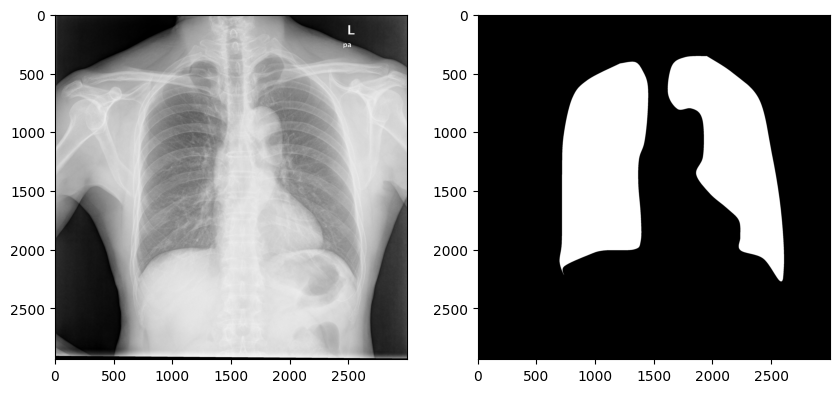

In [6]:
xray_num = 5
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

In [7]:
def load_image(path):
    img = resize( img_to_array( load_img(path) )/255. , (256,256))
    return img

In [8]:
images = zeros(shape=(len(paths_df["image_path"]), 256, 256, 3))
masks = zeros(shape=(len(paths_df["mask_path"]), 256, 256, 3))
for n, (img_path, mask_path) in tqdm(enumerate(zip(paths_df["image_path"], paths_df["mask_path"])), desc="Loading"):
    images[n] = load_image(img_path)
    masks[n] = load_image(mask_path)

Loading: 710it [17:28,  1.48s/it]


In [9]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(images, masks, test_size = 0.2, random_state= 42)

In [10]:
class Encoder(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c2(self.drop(self.c1(X)))
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling,
        }

In [11]:
class Decoder(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal', activation='relu')
        self.net = Encoder(filters, rate, pooling=False)

    def call(self, X):
        x, skip_x = X
        x = self.cT(x)

        c = concatenate([x, skip_x])
        f = self.net(c)
        return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate
        }

In [12]:
class AttentionGate(Layer):

    def __init__(self, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters

        self.normal = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', activation='relu')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal', activation='relu')

        self.learn = Conv2D(1, kernel_size=1, strides=1, activation='sigmoid')
        self.resample = UpSampling2D()

    def call(self, X):
        x, skip_x = X

        x = self.normal(x)
        skip = self.down(skip_x)
        a = add([x, skip])

        l = self.learn(a)
        l = self.resample(l)

        f = multiply([l, skip_x])
        return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters
        }

In [13]:
from keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
# Inputs
image_input = Input(shape=(256,256,3), name="InputImage")

# Encoder Phase
p1, c1 = Encoder(32, 0.1, name="EncoderBlock1")(image_input)
p2, c2 = Encoder(64, 0.1, name="EncoderBlock2")(p1)
p3, c3 = Encoder(128, 0.2, name="EncoderBlock3")(p2)
p4, c4 = Encoder(256, 0.2, name="EncoderBlock4")(p3)

# Latent Representation
encoding = Encoder(512, 0.3, pooling=False, name="Encoding")(p4)

# Deocder + Attention Phase
a1 = AttentionGate(256, name="Attention1")([encoding, c4])
d1 = Decoder(256, 0.2, name="DecoderBlock1")([encoding, a1])

a2 = AttentionGate(128, name="Attention2")([d1, c3])
d2 = Decoder(128, 0.2, name="DecoderBlock2")([d1, a2])

a3 = AttentionGate(64, name="Attention3")([d2, c2])
d3 = Decoder(64, 0.2, name="DecoderBlock3")([d2, a3])

a4 = AttentionGate(32, name="Attention4")([d3, c1])
d4 = Decoder(32, 0.1, name="DecoderBlock4")([d3, a4])

# Output Layer
mask_out = Conv2D(3, kernel_size=1, strides=1, activation='sigmoid', padding='same', name="MaskOut")(d4)

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# Model
att_unet = Model(
    inputs=[image_input], outputs=[mask_out], name="AttentionUNet"
)

# Compile
att_unet.compile(optimizer=Adam(learning_rate=5*1e-4), loss="binary_crossentropy",
                  metrics=[dice_coef,'binary_accuracy',Precision(),Recall(), MeanIoU(num_classes=2, name="IoU")])
att_unet.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'Encoding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `b

Model: "AttentionUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputImage (InputLayer)   │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EncoderBlock1 (Encoder)   │ [(None, 128, 128, 32), │         10,144 │ InputImage[0][0]       │
│                           │ (None, 256, 256, 32)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EncoderBlock2 (Encoder)   │ [(None, 64, 64, 64),   │         55,424 │ EncoderBlock1[0][0]    │
│                           │ (None, 128, 128, 64)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EncoderBlock3 (Encoder)   │ [(None, 32, 32, 128),  │        221,440 │ EncoderBlock2[0][0]    │
│                           │ (None, 64, 64, 128)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EncoderBlock4 (Encoder)   │ [(None, 16, 16, 256),  │        885,248 │ EncoderBlock3[0][0]    │
│                           │ (None, 32, 32, 256)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoding (Encoder)        │ (None, 16, 16, 512)    │      3,539,968 │ EncoderBlock4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention1                │ (None, 32, 32, 256)    │      1,770,241 │ Encoding[0][0],        │
│ (AttentionGate)           │                        │                │ EncoderBlock4[0][1]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DecoderBlock1 (Decoder)   │ (None, 32, 32, 256)    │      2,949,888 │ Encoding[0][0],        │
│                           │                        │                │ Attention1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention2                │ (None, 64, 64, 128)    │        442,753 │ DecoderBlock1[0][0],   │
│ (AttentionGate)           │                        │                │ EncoderBlock3[0][1]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DecoderBlock2 (Decoder)   │ (None, 64, 64, 128)    │        737,664 │ DecoderBlock1[0][0],   │
│                           │                        │                │ Attention2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention3                │ (None, 128, 128, 64)   │        110,785 │ DecoderBlock2[0][0],   │
│ (AttentionGate)           │                        │                │ EncoderBlock2[0][1]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DecoderBlock3 (Decoder)   │ (None, 128, 128, 64)   │        184,512 │ DecoderBlock2[0][0],   │
│                           │                        │                │ Attention3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention4                │ (None, 256, 256, 32)   │         27,745 │ DecoderBlock3[0][0],   │
│ (AttentionGate)           │                        │                │ EncoderBlock1[0][1]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DecoderBlock4 (Decoder)   │ (None, 256, 256, 32)   │         46,176 │ DecoderBlock3[0][0],   │
│                      

 Total params: 10,982,087 (41.89 MB)

 Trainable params: 10,982,087 (41.89 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [16]:

history = att_unet.fit(x = img_train,
                    y = mask_train,
                    validation_data = (img_test, mask_test),
                    epochs = 30,
                    batch_size = 16,
                   callbacks = [earlystopping])

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - IoU: 0.2934 - binary_accuracy: 0.5883 - dice_coef: 0.3235 - loss: 0.6977 - precision: 0.2499 - recall: 0.3188 - val_IoU: 0.3507 - val_binary_accuracy: 0.7417 - val_dice_coef: 0.4140 - val_loss: 0.4426 - val_precision: 0.0016 - val_recall: 6.9615e-06
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 69s 409ms/step - IoU: 0.2934 - binary_accuracy: 0.7482 - dice_coef: 0.4706 - loss: 0.3469 - precision: 0.2688 - recall: 0.0012 - val_IoU: 0.3507 - val_binary_accuracy: 0.7522 - val_dice_coef: 0.4682 - val_loss: 0.3716 - val_precision: 0.9676 - val_recall: 0.0383
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 418ms/step - IoU: 0.2936 - binary_accuracy: 0.8227 - dice_coef: 0.5597 - loss: 0.2667 - precision: 0.9663 - recall: 0.3049 - val_IoU: 0.3507 - val_binary_accuracy: 0.9321 - val_dice_coef: 0.5093 - val_loss: 0.3155 - val_precision: 0.9369 - val_recall: 0.7905
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - IoU: 0.2908 - binary_accuracy: 0.9314 - 

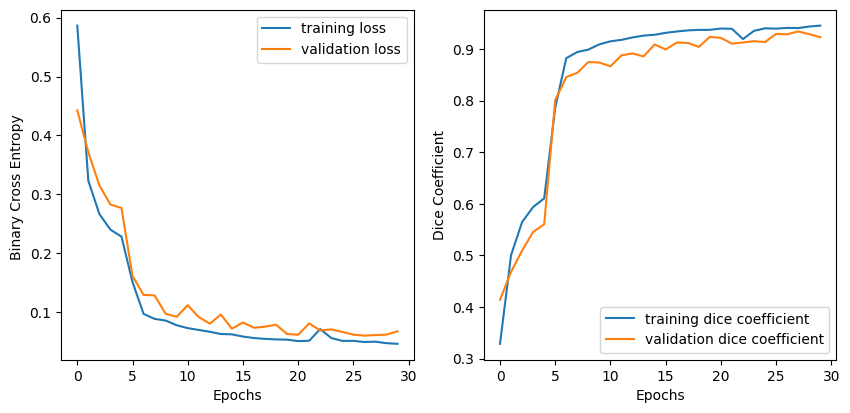

In [17]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy ")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")

get_metrics(history = history)

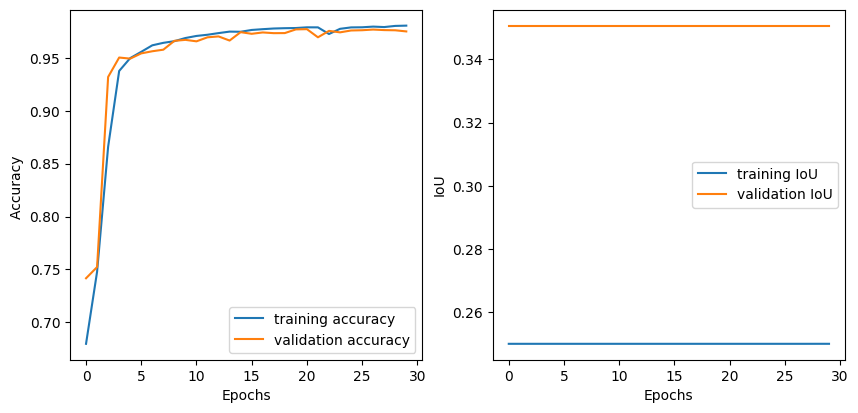

In [18]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["binary_accuracy"], label = "training accuracy")
    plt.plot(history.history["val_binary_accuracy"], label = "validation accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy ")

    plt.subplot(2,2,2)
    plt.plot(history.history["IoU"], label = "training IoU")
    plt.plot(history.history["val_IoU"], label = "validation IoU")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
get_metrics(history = history)

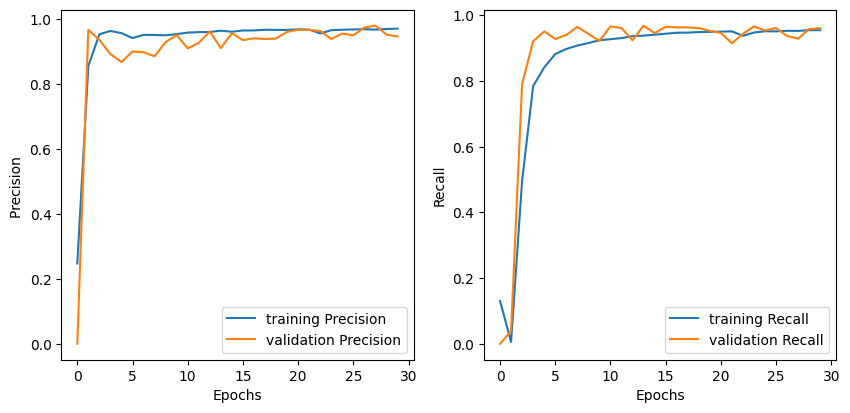

In [19]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["precision"], label = "training Precision")
    plt.plot(history.history["val_precision"], label = "validation Precision")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Precision ")

    plt.subplot(2,2,2)
    plt.plot(history.history["recall"], label = "training Recall")
    plt.plot(history.history["val_recall"], label = "validation Recall")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
get_metrics(history = history)

In [20]:
accuracy = history.history["val_binary_accuracy"]
precision = history.history["val_precision_2"]
recall = history.history["val_recall_2"]
iou = history.history["val_IoU"]
dice_coef = history.history["val_dice_coef"]
print("The Accuracy of the UNET model:",round(accuracy[-1],2))
print("The Precision of the UNET model:",round(precision[-1],2))
print("The Recall of the UNET model:",round(recall[-1],2))
print("The IOU Score of the UNET model:",round(iou[-1],2))
print("The Dice Score of the UNET model:",round(dice_coef[-1],2))


KeyError: 'val_precision_2'

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


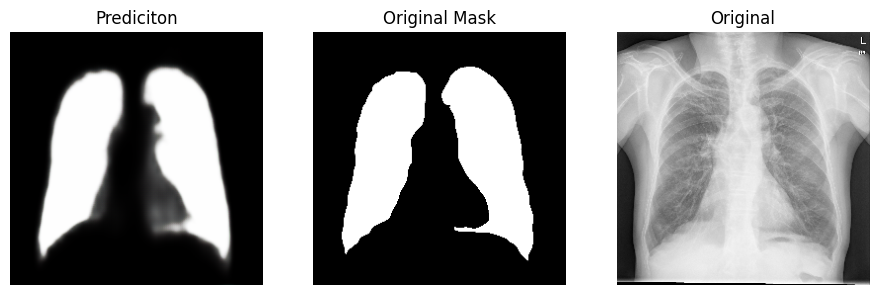

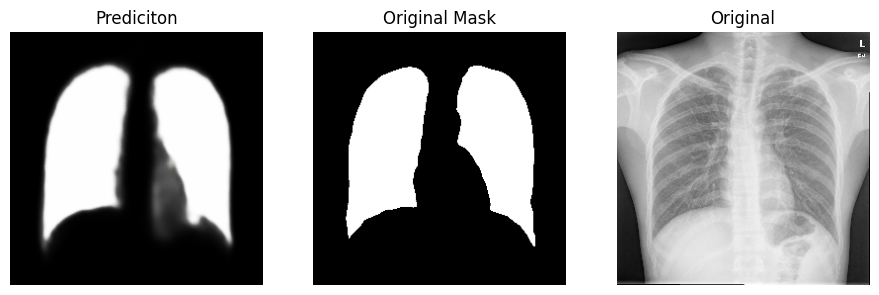

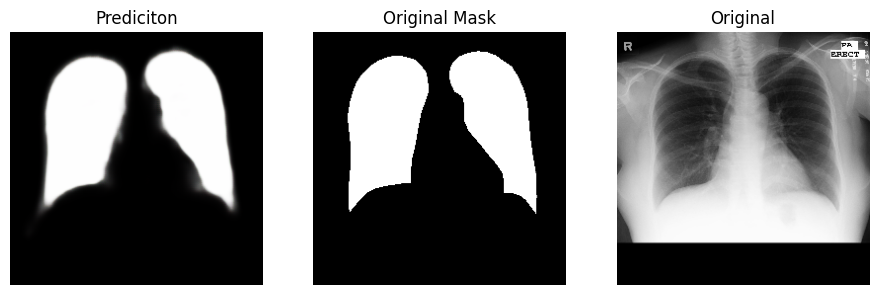

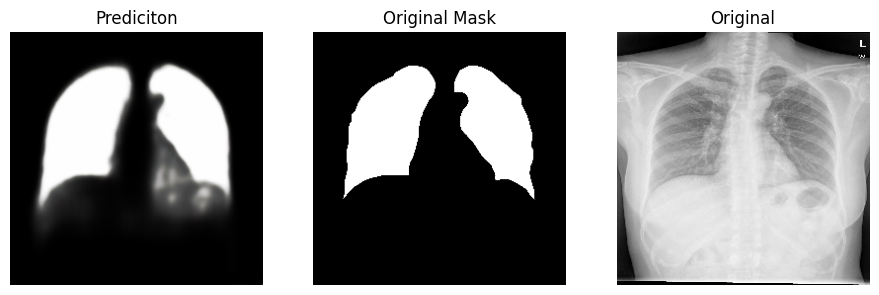

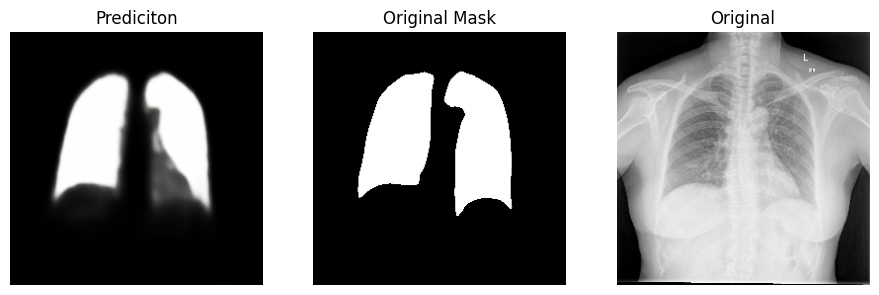

In [21]:
for i in range(5):
  id = random.randint(0,len(images))
  image,mask = images[id], masks[id]
  pred_mask = att_unet.predict(tf.expand_dims(image, axis=0))[0]

  fig = plt.figure(figsize = (15,10))

  plt.subplot(1,4,1)
  plt.imshow(pred_mask, cmap = "Blues")
  plt.title("Prediciton")
  plt.axis("off")

  plt.subplot(1,4,2)
  plt.imshow(masks[id],cmap = "Blues")
  plt.title("Original Mask");
  plt.axis("off")

  plt.subplot(1,4,3)
  plt.imshow(images[id], cmap = "gray")
  plt.title("Original")
  plt.axis("off")



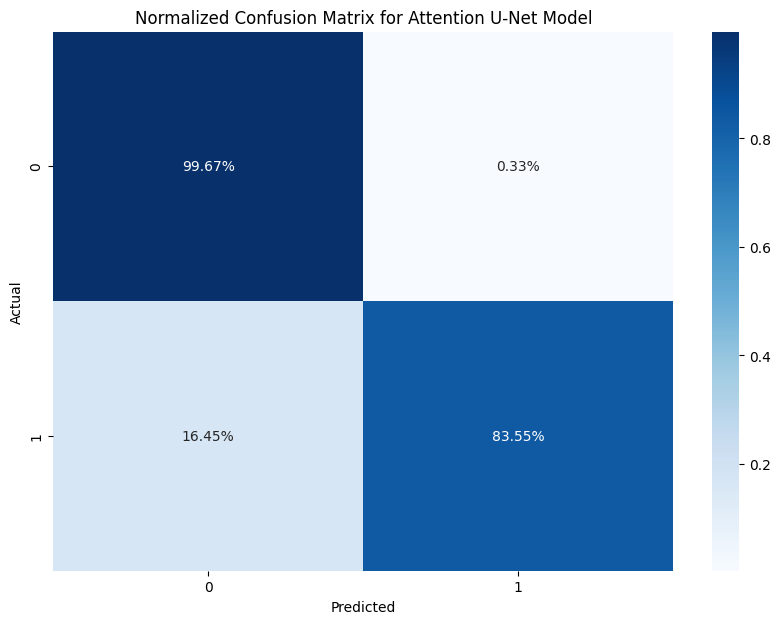

In [22]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have variables `pred_mask` (predicted probabilities) and `mask` (ground truth).

# Flatten the masks
y_true_flat = mask.flatten().astype(int)  # Ensure y_true is binary (0 or 1)
y_pred_flat = (pred_mask.flatten() > 0.5).astype(int)  # Convert probabilities to binary (0 or 1) using a threshold of 0.5

# Compute the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix for Attention U-Net Model')
plt.show()

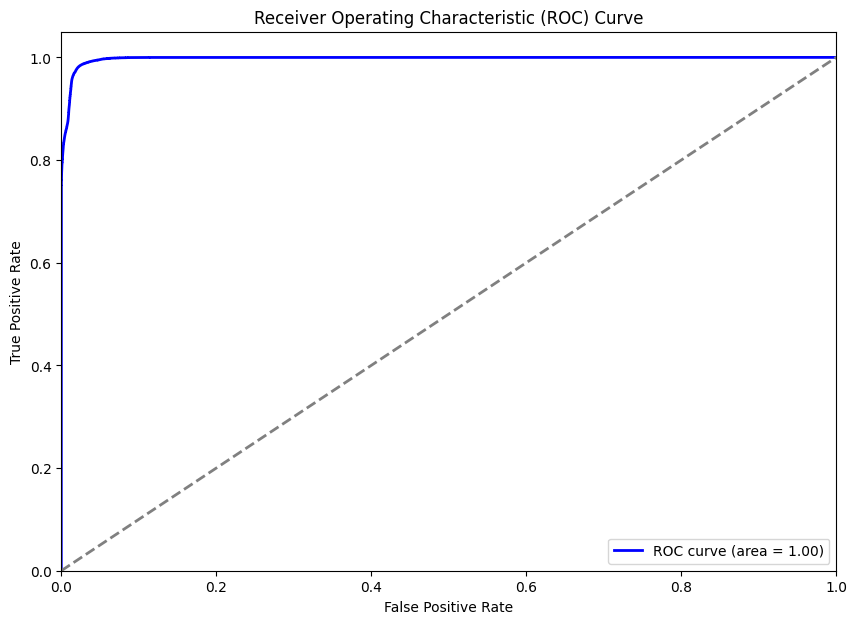

In [24]:
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming pred_mask contains the predicted probabilities and mask contains the ground truth

# Flatten the masks
y_true_flat = mask.flatten().astype(int)  # Ensure the ground truth is binary (0 or 1)
y_pred_flat = pred_mask.flatten()  # Keep the predictions as probabilities

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()